# Computing the SVD of the flow past a cylinder

In [1]:
from smartsim import Experiment
from smartsim import __version__ as version_smartsim
from smartredis import Client
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

plt.rcParams["figure.dpi"] = 180
version_smartsim

'0.8.0'

In [2]:
# location of OpenFOAM case
case_name = "cylinder2D"
# number of subdomains (MPI-ranks) in the OpenFOAM simulation
mpi_ranks = 4
# function object name
fo_name = "dataToSmartRedis"
# field of which to compute the SVD
field_name = "U"

## Setting up experiment and database

In [3]:
exp = Experiment("partitioned-svd-cylinder", launcher="local")
db = exp.create_database(port=8000, interface="lo")
exp.start(db)

## Running the simulation

In [4]:
# create blockMesh
blockMesh_settings = exp.create_run_settings(exe="blockMesh")
blockMesh_model = exp.create_model(name="blockMesh", run_settings=blockMesh_settings, path=case_name)
exp.start(blockMesh_model, summary=False, block=True) 
# create copy of original zero folder
cp_settings = exp.create_run_settings(exe="cp", exe_args=f"-r 0.org 0")
cp_model = exp.create_model(name="cp", run_settings=cp_settings, path=case_name)
exp.start(cp_model, summary=False, block=True) 
# set inlet velocity
setExp_settings = exp.create_run_settings(exe="setExprBoundaryFields")
setExp_model = exp.create_model(name="setExprBoundaryFields", run_settings=setExp_settings, path=case_name)
exp.start(setExp_model, summary=False, block=True)
# decompose domain
decomposePar_settings = exp.create_run_settings(exe="decomposePar")
decomposePar_model = exp.create_model(name="decomposePar", run_settings=decomposePar_settings, path=case_name)
exp.start(decomposePar_model, summary=False, block=True)
# renumber mesh cells
renumberMesh_settings = exp.create_run_settings(
    exe="renumberMesh", exe_args=f"-parallel -overwrite", 
    run_command="mpirun", run_args={"np": f"{mpi_ranks}"}
)
renumberMesh_model = exp.create_model(name="renumberMesh", run_settings=renumberMesh_settings, path=case_name)
exp.start(renumberMesh_model, summary=False, block=True)
# run the solver
pimpleFoam_settings = exp.create_run_settings(
    exe="pimpleFoam", exe_args=f"-parallel", 
    run_command="mpirun", run_args={"np": f"{mpi_ranks}"}
)
pimpleFoam_model = exp.create_model(name="pimpleFoam", run_settings=pimpleFoam_settings, path=case_name)
exp.start(pimpleFoam_model, summary=False, block=True)

11:14:39 andre-XP1511 SmartSim[28297:JobManager] INFO blockMesh(28425): SmartSimStatus.STATUS_COMPLETED
11:14:43 andre-XP1511 SmartSim[28297:JobManager] INFO cp(28627): SmartSimStatus.STATUS_COMPLETED
11:14:47 andre-XP1511 SmartSim[28297:JobManager] INFO setExprBoundaryFields(28650): SmartSimStatus.STATUS_COMPLETED
11:14:53 andre-XP1511 SmartSim[28297:JobManager] INFO decomposePar(28679): SmartSimStatus.STATUS_COMPLETED
11:14:59 andre-XP1511 SmartSim[28297:JobManager] INFO renumberMesh(28701): SmartSimStatus.STATUS_COMPLETED
11:15:07 andre-XP1511 SmartSim[28297:MainThread] INFO pimpleFoam(28755): SmartSimStatus.STATUS_RUNNING
11:15:12 andre-XP1511 SmartSim[28297:MainThread] INFO pimpleFoam(28755): SmartSimStatus.STATUS_RUNNING
11:15:17 andre-XP1511 SmartSim[28297:MainThread] INFO pimpleFoam(28755): SmartSimStatus.STATUS_RUNNING
11:15:22 andre-XP1511 SmartSim[28297:MainThread] INFO pimpleFoam(28755): SmartSimStatus.STATUS_RUNNING
11:15:27 andre-XP1511 SmartSim[28297:MainThread] INFO pim

## Connecting to the database

In [5]:
client = Client(address=db.get_address()[0], cluster=False)

SmartRedis Library@11-17-57:WARNING: Environment variable SR_LOG_FILE is not set. Defaulting to stdout
SmartRedis Library@11-17-57:WARNING: Environment variable SR_LOG_LEVEL is not set. Defaulting to INFO


## Computing the SVD

In [6]:
time_indices = list(range(10, 4001, 10))

In [7]:
def fetch_snapshot(time_index, mpi_rank):
    dataset_name = f"{fo_name}_time_index_{time_index}_mpi_rank_{mpi_rank}"
    if client.dataset_exists(dataset_name):
        dataset = client.get_dataset(dataset_name)
        return dataset.get_tensor(f"field_name_{field_name}_patch_internal").flatten()
    else:
        return None
    
def fetch_timeseries(time_indices, mpi_rank):
    return np.vstack([fetch_snapshot(ti, mpi_rank) for ti in time_indices]).T

In [8]:
def compute_partitioned_svd(svd_rank):
    # compute partial SVD for each MPI rank
    svd_settings = exp.create_run_settings(exe="python3", exe_args=f"partial_svd.py")
    params = {"mpi_rank" : list(range(mpi_ranks))}
    ensemble = exp.create_ensemble(f"svd_ensemble_r{svd_rank}", params=params, run_settings=svd_settings, perm_strategy="all_perm")
    config_file = "./partial_svd.py"
    ensemble.attach_generator_files(to_configure=config_file)
    exp.generate(ensemble, overwrite=True)
    exp.start(ensemble, summary=False, block=True)
    # assemble Y matrix and compute SVD
    Y = []
    for rank_i in range(mpi_ranks):
        s = client.get_tensor(f"svd_ensemble_r{svd_rank}_{rank_i}.partSVD_s_mpi_rank_{rank_i}")
        VT = client.get_tensor(f"svd_ensemble_r{svd_rank}_{rank_i}.partSVD_VT_mpi_rank_{rank_i}")
        Y.append(np.diag(s) @ VT)
    Y = np.concatenate(Y, axis=0)
    Uy, sy, VTy = np.linalg.svd(Y, full_matrices=False)
    client.put_tensor("partSVD_Uy", Uy)
    client.put_tensor("partSVD_sy", sy)
    client.put_tensor("partSVD_VTy", VTy)
    # compute global left singular vectors and reconstruction
    rec_settings = exp.create_run_settings(exe="python3", exe_args=f"reconstruction.py")
    params = {
        "mpi_rank" : list(range(mpi_ranks)),
        "svd_rank" : svd_rank
    }
    ensemble = exp.create_ensemble(f"rec_ensemble_r{svd_rank}", params=params, run_settings=rec_settings, perm_strategy="all_perm")
    config_file = "./reconstruction.py"
    ensemble.attach_generator_files(to_configure=config_file)
    exp.generate(ensemble, overwrite=True)
    exp.start(ensemble, summary=False, block=True)

In [9]:
def compute_reconstruction_error(svd_rank):
    rec = []
    for rank_i in range(mpi_ranks):
        rec_i = []
        name = f"rec_ensemble_r{svd_rank}_{rank_i}.rank_{svd_rank}_field_name_{field_name}_mpi_rank_{rank_i}_"
        for i, ti in enumerate(time_indices):
            name_i = name + f"time_index_{ti}"
            rec_i.append(client.get_tensor(name_i).flatten())
        data_i = fetch_timeseries(time_indices, rank_i)
        rec_i = np.vstack(rec_i).T
        rec.append(rec_i)
    rec = np.concatenate(rec, axis=0)
    data = [fetch_timeseries(time_indices, rank_i) for rank_i in range(mpi_ranks)]
    data = np.concatenate(data, axis=0)
    return np.linalg.norm(rec - data) / np.linalg.norm(data)

In [10]:
def compute_reconstruction_error_global(svd_rank):
    data = [fetch_timeseries(time_indices, rank_i) for rank_i in range(mpi_ranks)]
    data = np.concatenate(data, axis=0)
    U, s, VT = np.linalg.svd(data, full_matrices=False)
    rec = U[:, :svd_rank] @ np.diag(s[:svd_rank]) @ VT[:svd_rank]
    return np.linalg.norm(rec - data) / np.linalg.norm(data)

In [11]:
test_ranks = (2, 4, 8, 16)
for r in test_ranks:
    compute_partitioned_svd(r)

11:18:02 andre-XP1511 SmartSim[28297:JobManager] INFO svd_ensemble_r2_0(29042): SmartSimStatus.STATUS_COMPLETED
11:18:02 andre-XP1511 SmartSim[28297:JobManager] INFO svd_ensemble_r2_1(29058): SmartSimStatus.STATUS_COMPLETED
11:18:02 andre-XP1511 SmartSim[28297:JobManager] INFO svd_ensemble_r2_3(29091): SmartSimStatus.STATUS_COMPLETED
11:18:03 andre-XP1511 SmartSim[28297:MainThread] INFO svd_ensemble_r2_2(29074): SmartSimStatus.STATUS_COMPLETED
11:18:04 andre-XP1511 SmartSim[28297:JobManager] INFO svd_ensemble_r2_2(29074): SmartSimStatus.STATUS_COMPLETED
11:18:10 andre-XP1511 SmartSim[28297:JobManager] INFO rec_ensemble_r2_0(29219): SmartSimStatus.STATUS_COMPLETED
11:18:12 andre-XP1511 SmartSim[28297:JobManager] INFO rec_ensemble_r2_1(29235): SmartSimStatus.STATUS_COMPLETED
11:18:12 andre-XP1511 SmartSim[28297:JobManager] INFO rec_ensemble_r2_2(29251): SmartSimStatus.STATUS_COMPLETED
11:18:12 andre-XP1511 SmartSim[28297:JobManager] INFO rec_ensemble_r2_3(29267): SmartSimStatus.STATUS_CO

## Reconstruction error

In [12]:
part_svd_error = [compute_reconstruction_error(r) for r in test_ranks]

In [13]:
svd_error = [compute_reconstruction_error_global(r) for r in range(1, 21)]

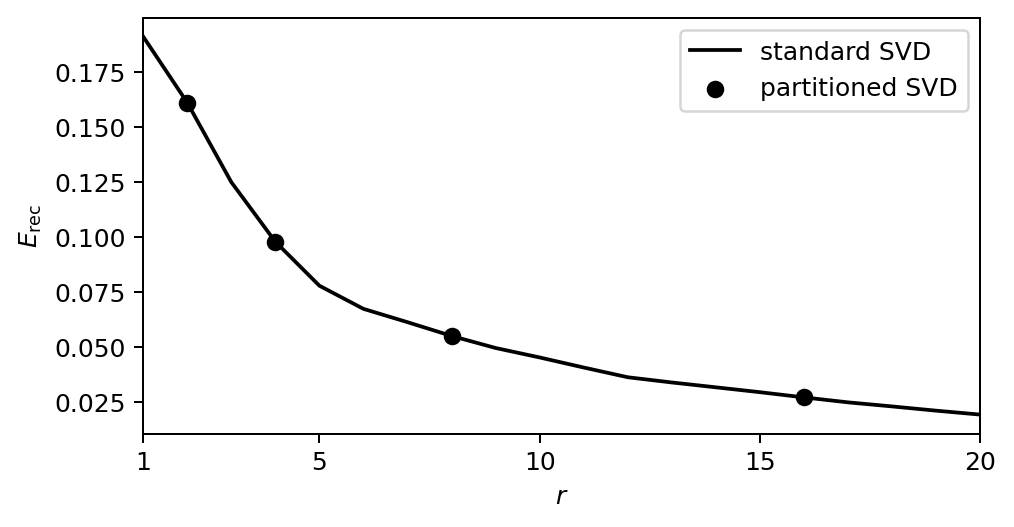

In [14]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(range(1, 21), svd_error, c="k", label="standard SVD")
ax.scatter(test_ranks, part_svd_error, c="k", marker="o", label="partitioned SVD")
ax.set_xticks([1, 5, 10, 15, 20])
ax.set_xlim(1, 20)
ax.legend()
ax.set_xlabel(r"$r$")
ax.set_ylabel(r"$E_\mathrm{rec}$")
plt.show()

## Transferring the data back to OpenFOAM

In [15]:
for r in test_ranks:
    settings = exp.create_run_settings(
        exe="svdToFoam",
        exe_args=f"-fieldName {field_name} -svdRank {r} -FOName {fo_name} -parallel",
        run_command="mpirun", run_args={"np": f"{mpi_ranks}"}
    )

    model = exp.create_model(name=f"svdToFoam_r{r}", run_settings=settings, path=case_name)
    exp.start(model, summary=False, block=True)

11:20:26 andre-XP1511 SmartSim[28297:JobManager] INFO svdToFoam_r2(30473): SmartSimStatus.STATUS_COMPLETED
11:20:30 andre-XP1511 SmartSim[28297:JobManager] INFO svdToFoam_r4(30540): SmartSimStatus.STATUS_COMPLETED
11:20:36 andre-XP1511 SmartSim[28297:JobManager] INFO svdToFoam_r8(30596): SmartSimStatus.STATUS_COMPLETED
11:20:40 andre-XP1511 SmartSim[28297:JobManager] INFO svdToFoam_r16(30656): SmartSimStatus.STATUS_COMPLETED


## Stopping the database

In [16]:
exp.stop(db)